In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from RGVSC import *
from typing import List, Dict

In [2]:
# 参数设置
Ug = 1
idref = 0.8
kppll =30
kipll = 6000
w0 = 100 * np.pi
Lg = 0.8 / w0
I_val = w0*Lg*idref/Ug
D_val = Lg*idref*(kipll*Ug/(1-kppll*Lg*idref))**(1/2)/Ug
alpha_val = kppll*(kipll*Ug/(1-kppll*Lg*idref))**(1/2)/kipll
print('故障前参数')
print('=========')
print('I_val=', I_val)
print('D_val=', D_val)
print('alpha_val=', alpha_val)

故障前参数
I_val= 0.6400000000000001
D_val= 0.16285445420050512
alpha_val= 0.39970496634428304


In [3]:
# 故障中参数
Ug_drop = 0.2
K1 = (kipll*Ug/(1-kppll*Lg*idref))**(1/2)
K2 = (kipll*Ug_drop/(1-kppll*Lg*idref))**(1/2)
# K2=1
I_fault = w0*Lg*idref/Ug_drop
D_fault = Lg*idref*(kipll*Ug_drop/(1-kppll*Lg*idref))**(1/2)/Ug_drop
alpha_fault = kppll*(kipll*Ug_drop/(1-kppll*Lg*idref))**(1/2)/kipll
print('故障中参数')
print('=========')
print('I_fault=', I_fault)
print('D_fault=', D_fault)
print('alpha_fault=', alpha_fault)

故障中参数
I_fault= 3.2000000000000006
D_fault= 0.36415363003095563
alpha_fault= 0.17875349513801647


In [4]:
# 算法超参数
epsilon_val = 1
tl_order = 5
rg_order = 5

In [5]:
I, alpha, D = sp.symbols('I alpha D')
x, y = sp.symbols('x y')
z, w = sp.symbols('z w')
t = sp.symbols('t')
epsilon = sp.symbols('epsilon')
a1, a2, b1, b2 = sp.symbols('a1 a2 b1 b2')
z0 = sp.symbols('a')  # 不稳定方向初始扰动幅值
a = sp.symbols('a')  # 同时符号化a增强可读性
w0 = 0   # 稳定方向初始扰动幅值
t0 = sp.symbols('t0')
a_t0 = sp.Function('a')(t0)
vec_unstable_sym = sp.Matrix([a1,a2])
vec_stable_sym = sp.Matrix([b1,b2])
# 鞍点表达式
xs_sym = sp.pi - sp.asin(I)
ys_sym = 0.0
# 鞍点数值
xs_val = float(xs_sym.subs(I, I_val).evalf())
ys_val = 0.0

In [6]:
params = {
    alpha:alpha_val,
    I: I_val,
    D: D_val,
    xs_sym:xs_val,
    ys_sym:ys_val,
    epsilon:epsilon_val,
}

In [7]:
J_sym = compute_sym_Jacobian(t,g=[x,y],original_func=original_func,params=params)
J_num = convert_sym_to_num_Jacobian(J_sym,params=params)
vec_stable_val, vec_unstable_val = compute_format_eigenvectors(J_num)
params.update({
    a1:vec_unstable_val[0],
    a2:vec_unstable_val[1],
    b1:vec_stable_val[0],
    b2:vec_stable_val[1], 
})

In [8]:
dxy_dt_tl = taylor_func(t, g=[x,y], 
                        tl_order=tl_order, 
                        original_func=original_func, 
                        xs_sym=xs_sym, 
                        ys_sym=ys_sym)
dzw_dt_sym = transform_dxy_to_dzw_sym(dxy_dt_tl)
dzw_dt_val = sub_func(dzw_dt_sym, params)
dz_dt, dw_dt = dzw_dt_val
dzw_dt_val

Matrix([
[  0.2491951272064*w + 0.2491951272064*z - 0.0224429210572177*(0.588644555608814*w - z)**5*(0.255811178460341*w + 0.255811178460341*z + 0.768374908491942) - 0.0754679475883449*(0.588644555608814*w - z)**4*(0.307123266938563*w + 0.307123266938563*z - 0.64) + 0.203018532166178*(0.588644555608814*w - z)**3*(0.255811178460341*w + 0.255811178460341*z + 0.768374908491942) - 0.409609566577853*(0.588644555608814*w - z)**2*(-0.307123266938563*w - 0.307123266938563*z + 0.64) - 0.370532573526637*(0.875265838972534*w - 1.48691741159022*z)*(0.255811178460341*w + 0.255811178460341*z + 0.768374908491942)],
[-0.719172848345468*w - 0.719172848345468*z - 0.0381264395353249*(0.588644555608814*w - z)**5*(0.255811178460341*w + 0.255811178460341*z + 0.768374908491942) - 0.128206312059221*(0.588644555608814*w - z)**4*(0.307123266938563*w + 0.307123266938563*z - 0.64) + 0.34489154827263*(0.588644555608814*w - z)**3*(0.255811178460341*w + 0.255811178460341*z + 0.768374908491942) - 0.69585212786723*(0.

In [9]:
equations = get_perturbation_equations(dzw_dt_sym, rg_order=rg_order, remove_coupling=True)
equations_num = convert_sym_to_num_Eqations(equations, params)
for i in equations_num:
    print(f"\n=== {i} 阶方程 ===")
    print("dz/dt 方程:", equations_num[i][0])
    print("dw/dt 方程:", equations_num[i][1])


=== 1 阶方程 ===
dz/dt 方程: Eq(Derivative(z1(t), t), 0.672532308926643*z1(t))
dw/dt 方程: Eq(Derivative(w1(t), t), -1.14251003006571*w1(t))

=== 2 阶方程 ===
dz/dt 方程: Eq(Derivative(z2(t), t), -0.173798925430347*w1(t)**2 + 0.366602719751217*w1(t)*z1(t) - 0.121210612293853*z1(t)**2 + 0.672532308926643*z2(t))
dw/dt 方程: Eq(Derivative(w2(t), t), -0.29525275274243*w1(t)**2 + 0.6227913199198*w1(t)*z1(t) - 1.14251003006571*w2(t) - 0.205914776818906*z1(t)**2)

=== 3 阶方程 ===
dz/dt 方程: Eq(Derivative(z3(t), t), 0.0754078823932406*w1(t)**3 - 0.266670740519426*w1(t)**2*z1(t) - 0.347597850860694*w1(t)*w2(t) + 0.253172585994799*w1(t)*z1(t)**2 + 0.366602719751217*w1(t)*z2(t) + 0.366602719751217*w2(t)*z1(t) - 0.0301937178186762*z1(t)**3 - 0.242421224587706*z1(t)*z2(t) + 0.672532308926643*z3(t))
dw/dt 方程: Eq(Derivative(w3(t), t), 0.128104272221203*w1(t)**3 - 0.453025069166941*w1(t)**2*z1(t) - 0.590505505484861*w1(t)*w2(t) + 0.430094160529442*w1(t)*z1(t)**2 + 0.6227913199198*w1(t)*z2(t) + 0.6227913199198*w2(t)*z

In [10]:
solutions = solve_perturbation_orders(equations_num, rg_order)
print("=== 各阶解 ===")
for key in sorted(solutions.keys()):
    solutions[key] = solutions[key].subs({t:t-t0,z0:a_t0})
    print(f"{key} = {solutions[key].simplify().expand()}")

=== 各阶解 ===
w1 = 0
w2 = -0.082777325693991*a(t0)**2*exp(1.34506461785329*t)*exp(-1.34506461785329*t0)
w3 = -0.02983794294561*a(t0)**3*exp(1.34506461785329*t)*exp(-1.34506461785329*t0) - 0.00905745372818048*a(t0)**3*exp(2.01759692677993*t)*exp(-2.01759692677993*t0)
w4 = -0.0155180075532648*a(t0)**4*exp(1.34506461785329*t)*exp(-1.34506461785329*t0) - 0.00489727927258174*a(t0)**4*exp(2.01759692677993*t)*exp(-2.01759692677993*t0) - 0.00173701063103902*a(t0)**4*exp(2.69012923570657*t)*exp(-2.69012923570657*t0) - 0.00190168355160153*a(t0)**4*exp(2.69012923570658*t)*exp(-2.69012923570658*t0)
w5 = -0.00970069449452246*a(t0)**5*exp(1.34506461785329*t)*exp(-1.34506461785329*t0) - 0.00298827771805916*a(t0)**5*exp(2.01759692677993*t)*exp(-2.01759692677993*t0) - 0.00125224688452633*a(t0)**5*exp(2.69012923570657*t)*exp(-2.69012923570657*t0) - 0.00137096299832287*a(t0)**5*exp(2.69012923570658*t)*exp(-2.69012923570658*t0) - 0.00229994243752188*a(t0)**5*exp(3.36266154463321*t)*exp(-3.36266154463321*t0)

In [11]:
z_expr = 0
w_expr = 0
epsilon = sp.symbols('epsilon')
for i in range(1,rg_order+1):
    z_expr += epsilon**i*solutions[f'z{i}']
    w_expr += epsilon**i*solutions[f'w{i}']

zw_expr = [z_expr, w_expr]
zw_expr

[epsilon**5*(0.0266045679219525*exp(0.672532308926643*t - 0.672532308926643*t0) - 0.0211212164941725*exp(1.34506461785329*t - 1.34506461785329*t0) - 0.00413268897310357*exp(2.01759692677993*t - 2.01759692677993*t0) - 0.00140025337598147*exp(2.69012923570657*t - 2.69012923570657*t0) - 0.00153300087264615*exp(2.69012923570658*t - 2.69012923570658*t0) - 0.00226729635195662*exp(3.36266154463321*t - 3.36266154463321*t0) + 0.00384988814590774*exp(3.36266154463322*t - 3.36266154463322*t0))*a(t0)**5 + epsilon**4*(0.0446287251025213*exp(0.672532308926643*t - 0.672532308926643*t0) - 0.0337871888735162*exp(1.34506461785329*t - 1.34506461785329*t0) - 0.00677277480794249*exp(2.01759692677993*t - 2.01759692677993*t0) - 0.00194231267834067*exp(2.69012923570657*t - 2.69012923570657*t0) - 0.00212644874272193*exp(2.69012923570658*t - 2.69012923570658*t0))*a(t0)**4 + epsilon**3*(0.0774919863778576*exp(0.672532308926643*t - 0.672532308926643*t0) - 0.0649658282766091*exp(1.34506461785329*t - 1.345064617853

In [12]:
da_dt0_expr = derive_da_dt0(z_expr)
da_dt = convert_derivative(da_dt0_expr)
da_dt

-0.0214241825148775*a**5 - 0.0400419164430348*a**4 - 0.0605401105518257*a**3 - 0.121210612293853*a**2 + 0.672532308926643*a

In [13]:
f1_expr,f2_expr = taylor_func(t,[x,y])
taylor_f1expr = sp.series(f1_expr, y, ys_sym, n=tl_order+1).removeO()
taylor_f2expr = sp.series(f2_expr, x, xs_sym, n=tl_order+1).removeO()

# 代入实际参数值
taylor_f1substituted = taylor_f1expr.subs(params)
taylor_f2substituted = taylor_f2expr.subs(params)
taylor_f1_func = sp.lambdify((x, y), taylor_f1substituted, 'numpy')
taylor_f2_func = sp.lambdify((x, y), taylor_f2substituted, 'numpy')
def original_ode_system(t, g):
    x, y = g
    dx = -y
    dy = -I_val + np.sin(x) + (alpha_val * np.cos(x) - D_val) * y
    return [dx, dy]

def taylor_ode_system(t, g):
    x, y = g
    return [
        taylor_f1_func(x, y),  # dx/dt = f1(x, y)
        taylor_f2_func(x, y)   # dy/dt = f2(x, y)
    ]

da_dt_func = sp.lambdify((t, a), da_dt, modules='numpy')
def rg_system(t, a):
    return da_dt_func(t,a)

In [14]:
zw_funcs = create_zw_functions(zw_expr, epsilon_val)

# 使用符号表达式计算初始值
z0 = 0.001
w0 = 0
x0, y0 = transform_z_w_to_x_y(z0, w0)
xlim = (-2, 3.5)
ylim = (-2, 2)
# 数值积分时间范围
t_span = [0, 20]
t_eval = np.linspace(*t_span, 500)
t_span_long = [0, 13]
t_eval_long = np.linspace(*t_span_long, 1000)
# 求解数值解
num_sol = solve_ivp(original_ode_system, t_span, [x0, y0], t_eval=t_eval, method='RK45')
x_num = num_sol.y[0]
y_num = num_sol.y[1]
taylor_sol  = solve_ivp(taylor_ode_system, t_span, [x0, y0], t_eval=t_eval, method='RK45')
rg_sol = solve_ivp(rg_system, t_span_long, [z0], method='RK45', rtol=1e-12, atol=1e-12)
a_array = rg_sol.y[0]
x_rg, y_rg = rg_xy_func(a_array, zw_funcs)
# 流场线计算
x_grid, y_grid = np.meshgrid(np.linspace(xlim[0],xlim[1], 20), np.linspace(ylim[0],ylim[1], 20))
dx_grid = y_grid
dy_grid = I_val - np.sin(x_grid) - (alpha_val * np.cos(x_grid) - D_val) * y_grid

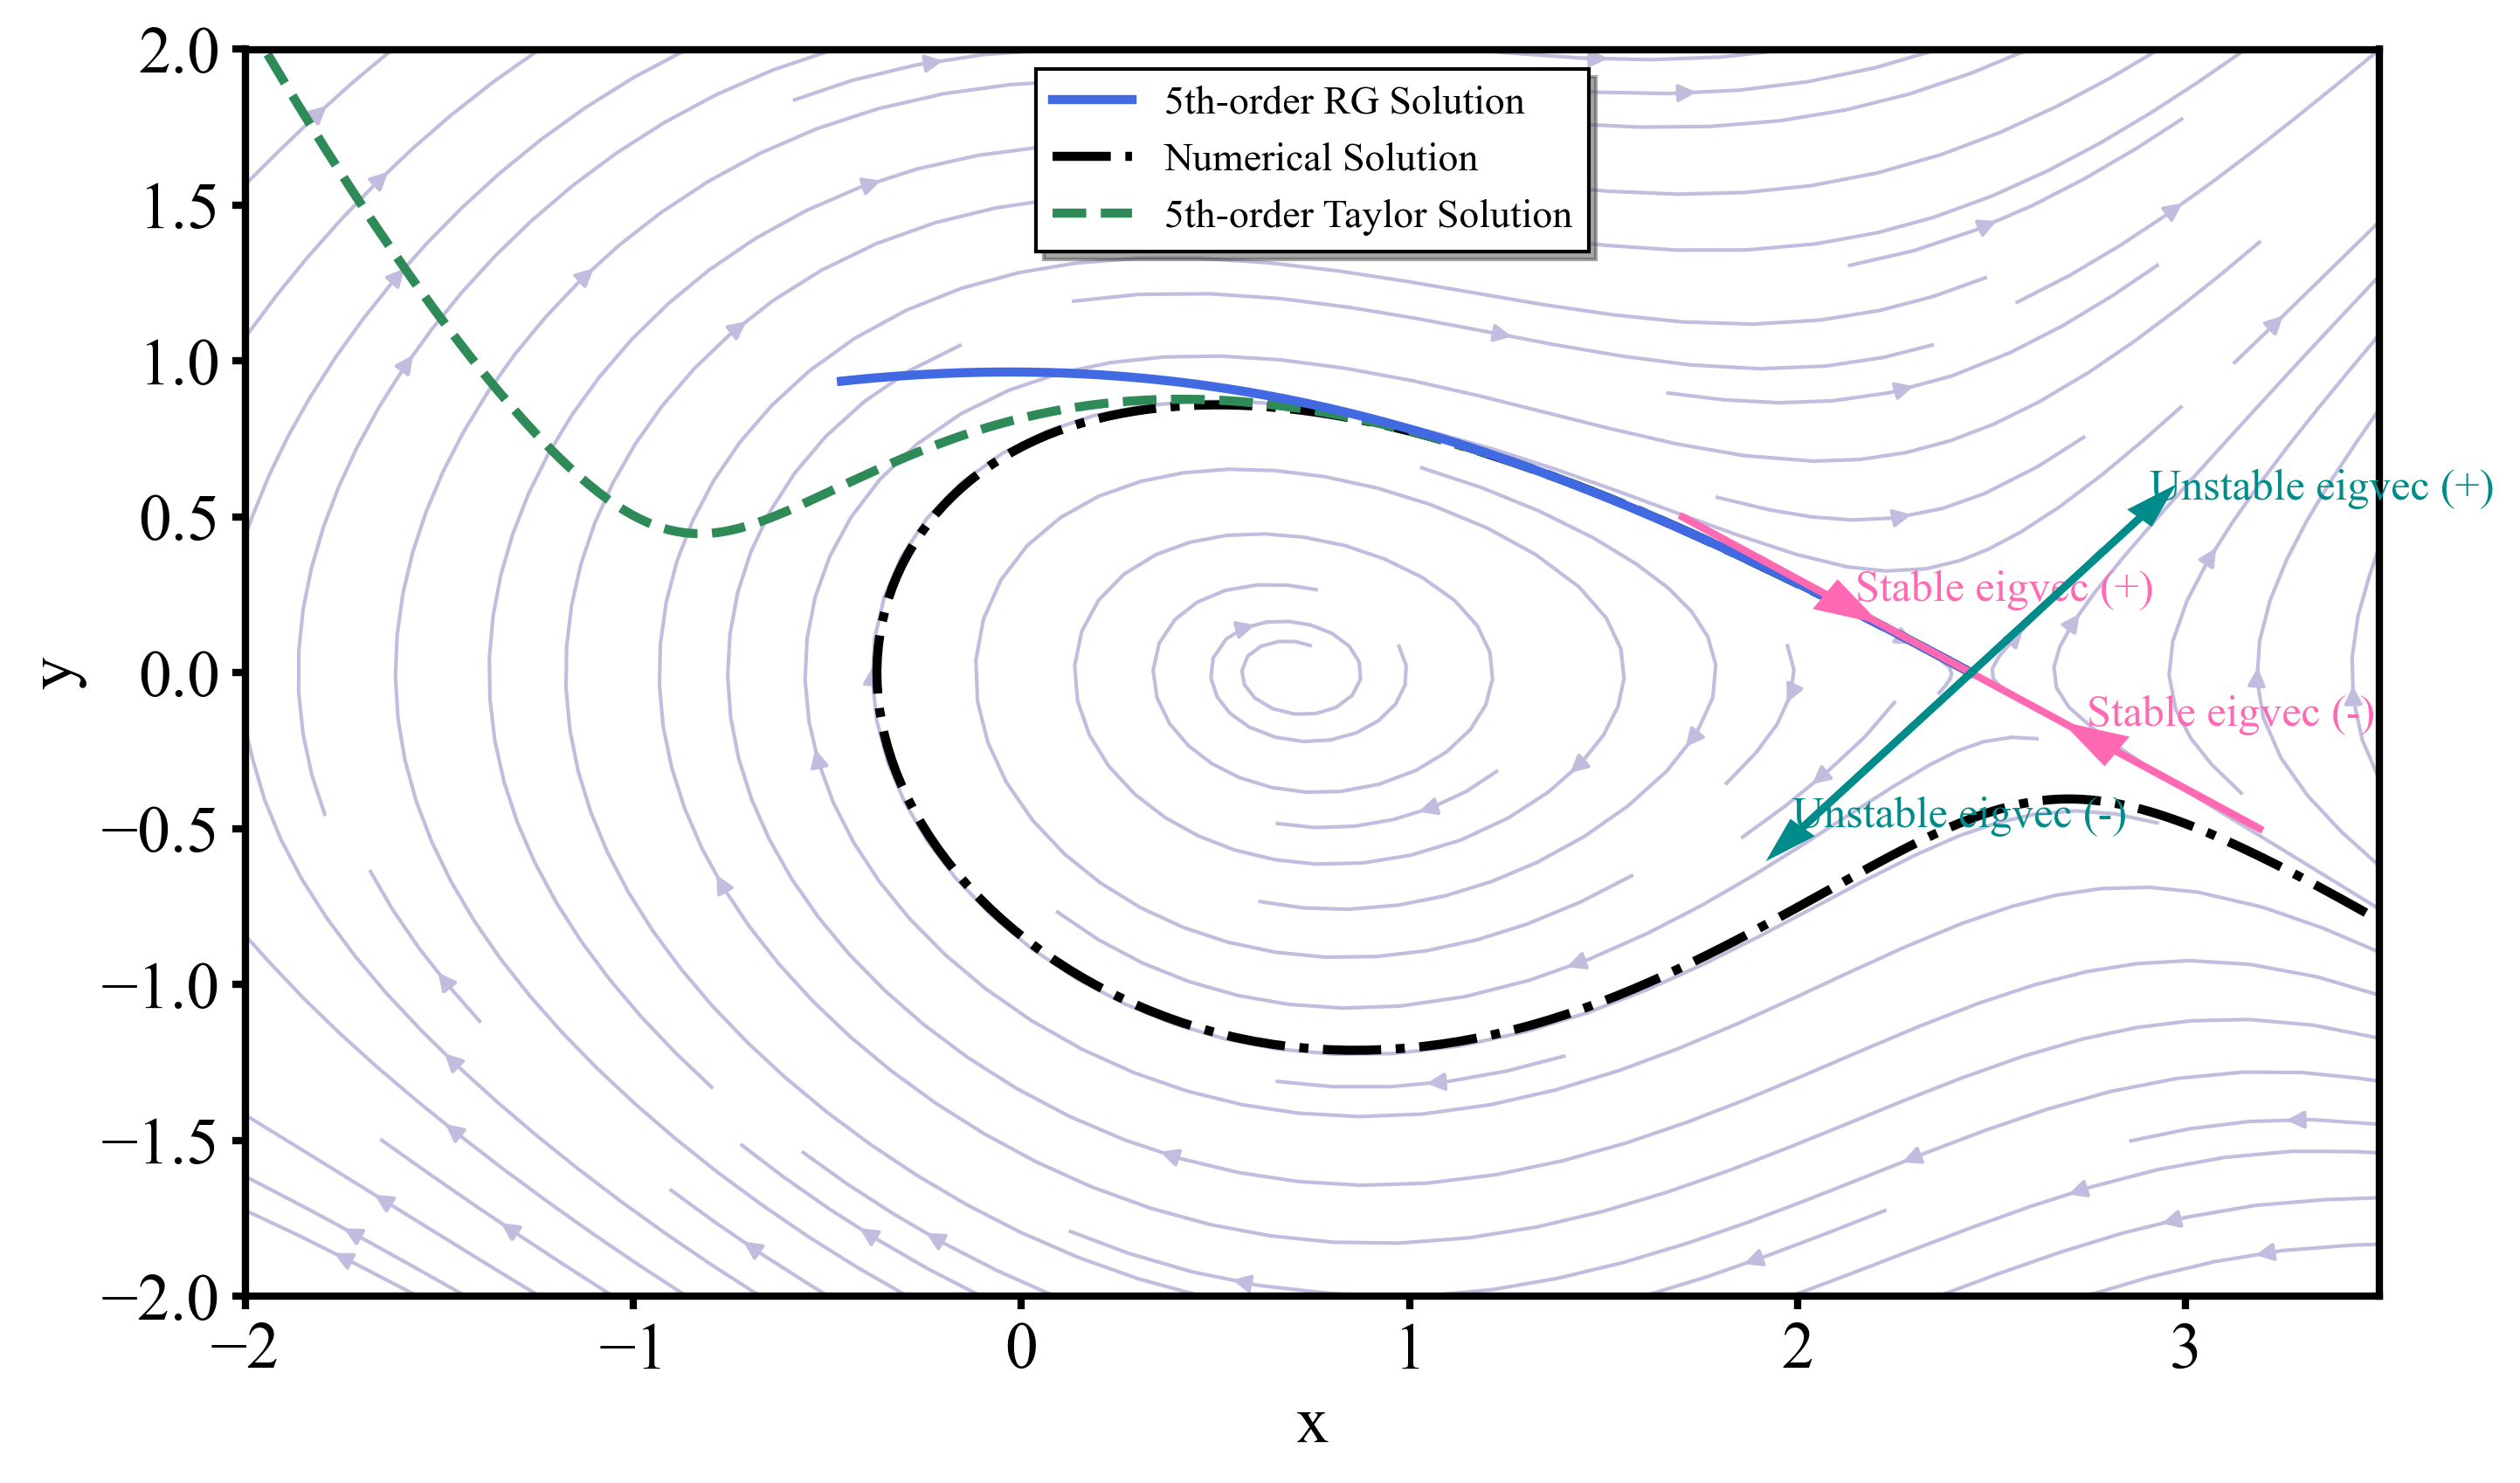

In [15]:
plt.figure(figsize=(10, 6))

# 1. 摄动解
plt.plot(x_rg, y_rg , label=f'{rg_order}th-order RG Solution', color='royalblue', linewidth=2.5, zorder=5)

# 2. 数值解
plt.plot(x_num,y_num, linestyle='-.', label='Numerical Solution', color='black', linewidth=2.5)

# 3. 泰勒展开对比
plt.plot(taylor_sol.y[0],taylor_sol.y[1], linestyle='--', label=f'{tl_order}th-order Taylor Solution', color='seagreen', linewidth=2.5)


# 4. 相空间流场
plt.streamplot(x_grid, y_grid, dx_grid, dy_grid, color='#c2bdde', density=1, linewidth=1, arrowsize=1,zorder=0)
arrow_scale = 0.5

# 计算并填充面积
y_values = num_sol.y[1]
max_y_index = np.argmax(y_values)
xm = num_sol.y[0][max_y_index]  # 数值解y最大值对应的x坐标

# 截取数值解在[xm, xs_val]区间的部分（注意时间序列方向）
num_valid_mask = (num_sol.y[0] >= xm) & (num_sol.y[0] <= x0)
x_num_segment = num_sol.y[0][num_valid_mask]
y_num_segment = num_sol.y[1][num_valid_mask]

# 截取RG解在[xm, xs_val]区间的部分（注意RG解x的单调性）
rg_valid_mask = (x_rg >= xm) & (x_rg <= x0)
x_rg_segment = x_rg[rg_valid_mask]
y_rg_segment = y_rg[rg_valid_mask]

# 确保数据点按x升序排列
x_num_segment, y_num_segment = zip(*sorted(zip(x_num_segment, y_num_segment)))
x_rg_segment, y_rg_segment = zip(*sorted(zip(x_rg_segment, y_rg_segment)))

# 使用精细插值处理反向y值

# 生成插值范围[xm, xs_val]
x_interp = np.linspace(xm, x0, 1000)

# 对数值解进行插值
f_num = interp1d(x_num_segment, y_num_segment, 
                kind='quadratic', 
                bounds_error=False,
                fill_value=(y_num_segment[0], y_num_segment[-1]))
y_num_interp = f_num(x_interp)

# 对RG解进行插值
f_rg = interp1d(x_rg_segment, y_rg_segment,
               kind='quadratic',
               bounds_error=False,
               fill_value=(y_rg_segment[0], y_rg_segment[-1]))
y_rg_interp = f_rg(x_interp)

# 确定上下边界
upper_curve = np.maximum(y_num_interp, y_rg_interp)
lower_curve = np.minimum(y_num_interp, y_rg_interp)

# 稳定流形正向：箭头从外侧指向鞍点
# 计算线段起点和终点
arrow_scale = 0.5
end_x = xs_val 
end_y = ys_val
start_x = xs_val + vec_unstable_val[0]*arrow_scale
start_y = ys_val + vec_unstable_val[1]*arrow_scale
# --- 绘制线段（不带箭头）---
plt.plot([start_x, end_x], [start_y, end_y],color='#FF69B4', linewidth=2, zorder=10)
# --- 在中间位置绘制箭头 ---
mid_x = (start_x + end_x) * 0.5  # 中点 x
mid_y = (start_y + end_y) * 0.5  # 中点 y
# 箭头方向（从中点指向终点）
arrow_dx = -vec_unstable_val[0] * arrow_scale * 0.5
arrow_dy = -vec_unstable_val[1] * arrow_scale * 0.5
plt.arrow(
    start_x, start_y,  # 箭头起点（中点）
    arrow_dx, arrow_dy,  # 方向（指向终点）
    width=0.01, head_width=0.1, head_length=0.15,
    fc='#FF69B4', ec='#FF69B4', zorder=5)
 
plt.text( mid_x + arrow_dx * 0.2, mid_y + arrow_dy * 0.2,
    'Stable eigvec (+)', color='#FF69B4', fontsize=12, ha='left', va='bottom')

# 稳定流形负向
end_x = xs_val 
end_y = ys_val
start_x = xs_val - vec_unstable_val[0]*arrow_scale
start_y = ys_val - vec_unstable_val[1]*arrow_scale
# --- 绘制线段（不带箭头）---
plt.plot([start_x, end_x], [start_y, end_y],color='#FF69B4', linewidth=2, zorder=10)
# --- 在中间位置绘制箭头 ---
mid_x = (start_x + end_x) * 0.5  # 中点 x
mid_y = (start_y + end_y) * 0.5  # 中点 y
# 箭头方向（从中点指向终点）
arrow_dx = vec_unstable_val[0] * arrow_scale * 0.5
arrow_dy = vec_unstable_val[1] * arrow_scale * 0.5
plt.arrow(
    start_x, start_y,  # 箭头起点（中点）
    arrow_dx, arrow_dy,  # 方向（指向终点）
    width=0.01, head_width=0.1, head_length=0.15,
    fc='#FF69B4', ec='#FF69B4', zorder=5)
 
plt.text( mid_x + arrow_dx * 0.2, mid_y + arrow_dy * 0.2,
    'Stable eigvec (-)', color='#FF69B4', fontsize=12, ha='left', va='bottom')

# 不稳定流形正向：从鞍点出发
plt.arrow(xs_val, ys_val, vec_stable_val[0]*arrow_scale, vec_stable_val[1]*arrow_scale,
          width=0.012, head_width=0.07, head_length=0.12, fc='#008B8B', ec='#008B8B', zorder=10)
plt.text(xs_val + vec_stable_val[0]*arrow_scale*1.05, ys_val + vec_stable_val[1]*arrow_scale*1.05,
         'Unstable eigvec (+)', color='#008B8B', fontsize=12, ha='left', va='bottom')

# 不稳定流形负向：从鞍点出发
plt.arrow(xs_val, ys_val, -vec_stable_val[0]*arrow_scale, -vec_stable_val[1]*arrow_scale,
          width=0.012, head_width=0.07, head_length=0.12, fc='#008B8B', ec='#008B8B', zorder=10)
plt.text(xs_val - vec_stable_val[0]*arrow_scale*1.05, ys_val - vec_stable_val[1]*arrow_scale*1.05,
         'Unstable eigvec (-)', color='#008B8B', fontsize=12, ha='left', va='bottom')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(frameon=True,edgecolor='black',fancybox=False,shadow=True,)
plt.show()

In [16]:
# 初始稳定点表达式
xini_sym = sp.asin(I)
yini_sym = 0.0
# 稳定点数值
xini_val = float(xini_sym.subs(I, I_val).evalf())
yini_val = 0.0

def fault_system(t, g):
    x, y = g
    dx = y
    dy = I_fault - np.sin(x) - (alpha_fault * np.cos(x) - D_fault) * y
    return [dx, dy]

t_span_fault = [0,3]
delta_t = 1e-6
num_t = int(t_span_fault[1]/delta_t)
t_eval_fault = np.linspace(*t_span_fault,num_t)
fault_sol = solve_ivp(fault_system, 
                    t_span_fault, 
                    [xini_val, yini_val], 
                    t_eval=t_eval_fault, 
                    method='RK45')
x_fault = fault_sol.y[0]
y_fault = fault_sol.y[1]*K2/K1

x_linear = np.linspace(-2, 4, 500)
k = vec_unstable_val[1]/vec_unstable_val[0]
y_linear = ys_val + k * (x_linear - xs_val)

In [17]:
from scipy.spatial import KDTree
def find_intersection(curve1, curve2, threshold=1e-2):
    """
    查找两条曲线的第一个交点索引（在curve1上的位置）
    
    参数:
    curve1: (n,2)数组，第一条曲线点集
    curve2: (m,2)数组，第二条曲线点集
    threshold: 交点判定阈值
    
    返回:
    curve1上的交点索引，若无交点返回None
    """
    # 使用KDTree加速最近邻搜索
    tree = KDTree(curve2)
    dists, indices = tree.query(curve1, k=1)
    
    # 找到距离小于阈值的第一个点
    for i, dist in enumerate(dists):
        if dist < threshold:
            return i
    return None

# 准备曲线数据（转换为二维点集）
curve_fault = np.column_stack((x_fault, y_fault))
curve_rg = np.column_stack((x_interp, y_rg_interp))
curve_num = np.column_stack((x_num, y_num))
curve_linear = np.column_stack((x_linear, y_linear))

# 检测交点
idx_rg = find_intersection(curve_fault, curve_rg)
idx_num = find_intersection(curve_fault, curve_num)
idx_linear = find_intersection(curve_fault, curve_linear)

print(f"故障曲线与摄动解的交点索引: {idx_rg}")
print(f"故障曲线与数值解的交点索引: {idx_num}")
print(f"故障曲线与线性近似的交点索引: {idx_linear}")



故障曲线与摄动解的交点索引: 597865
故障曲线与数值解的交点索引: 598483
故障曲线与线性近似的交点索引: 658349


In [18]:
def aft_fault_system(t, g):
    x, y = g
    dx = y
    dy = I_val - np.sin(x) - (alpha_val * np.cos(x) - D_val) * y
    return [dx, dy]
# 故障后曲线
def get_aft_sol(t_end_fault = 1, t_span_aft=[0, 1]):
    t_index = int(num_t*t_end_fault/t_span_fault[1])
    x_aft_fault_ini = x_fault[t_index]
    y_aft_fault_ini = y_fault[t_index]
    t_eval_aft = np.linspace(*t_span_aft, 500)
    # 求解故障后数值解
    aft_sol = solve_ivp(aft_fault_system, t_span_aft, [x_aft_fault_ini, y_aft_fault_ini], t_eval=t_eval_aft, method='RK45')
    x_aft = aft_sol.y[0]
    y_aft = aft_sol.y[1]
    return x_aft, y_aft


In [19]:
# 故障后曲线1
t_end_fault_1 = 0.5
t_end_fault_1 = x_aft_1, y_aft_1 = get_aft_sol(t_end_fault = t_end_fault_1, t_span_aft=[0, 3])
t_end_fault_2 = 0.75
x_aft_2, y_aft_2 = get_aft_sol(t_end_fault = t_end_fault_2, t_span_aft=[0, 1.1])

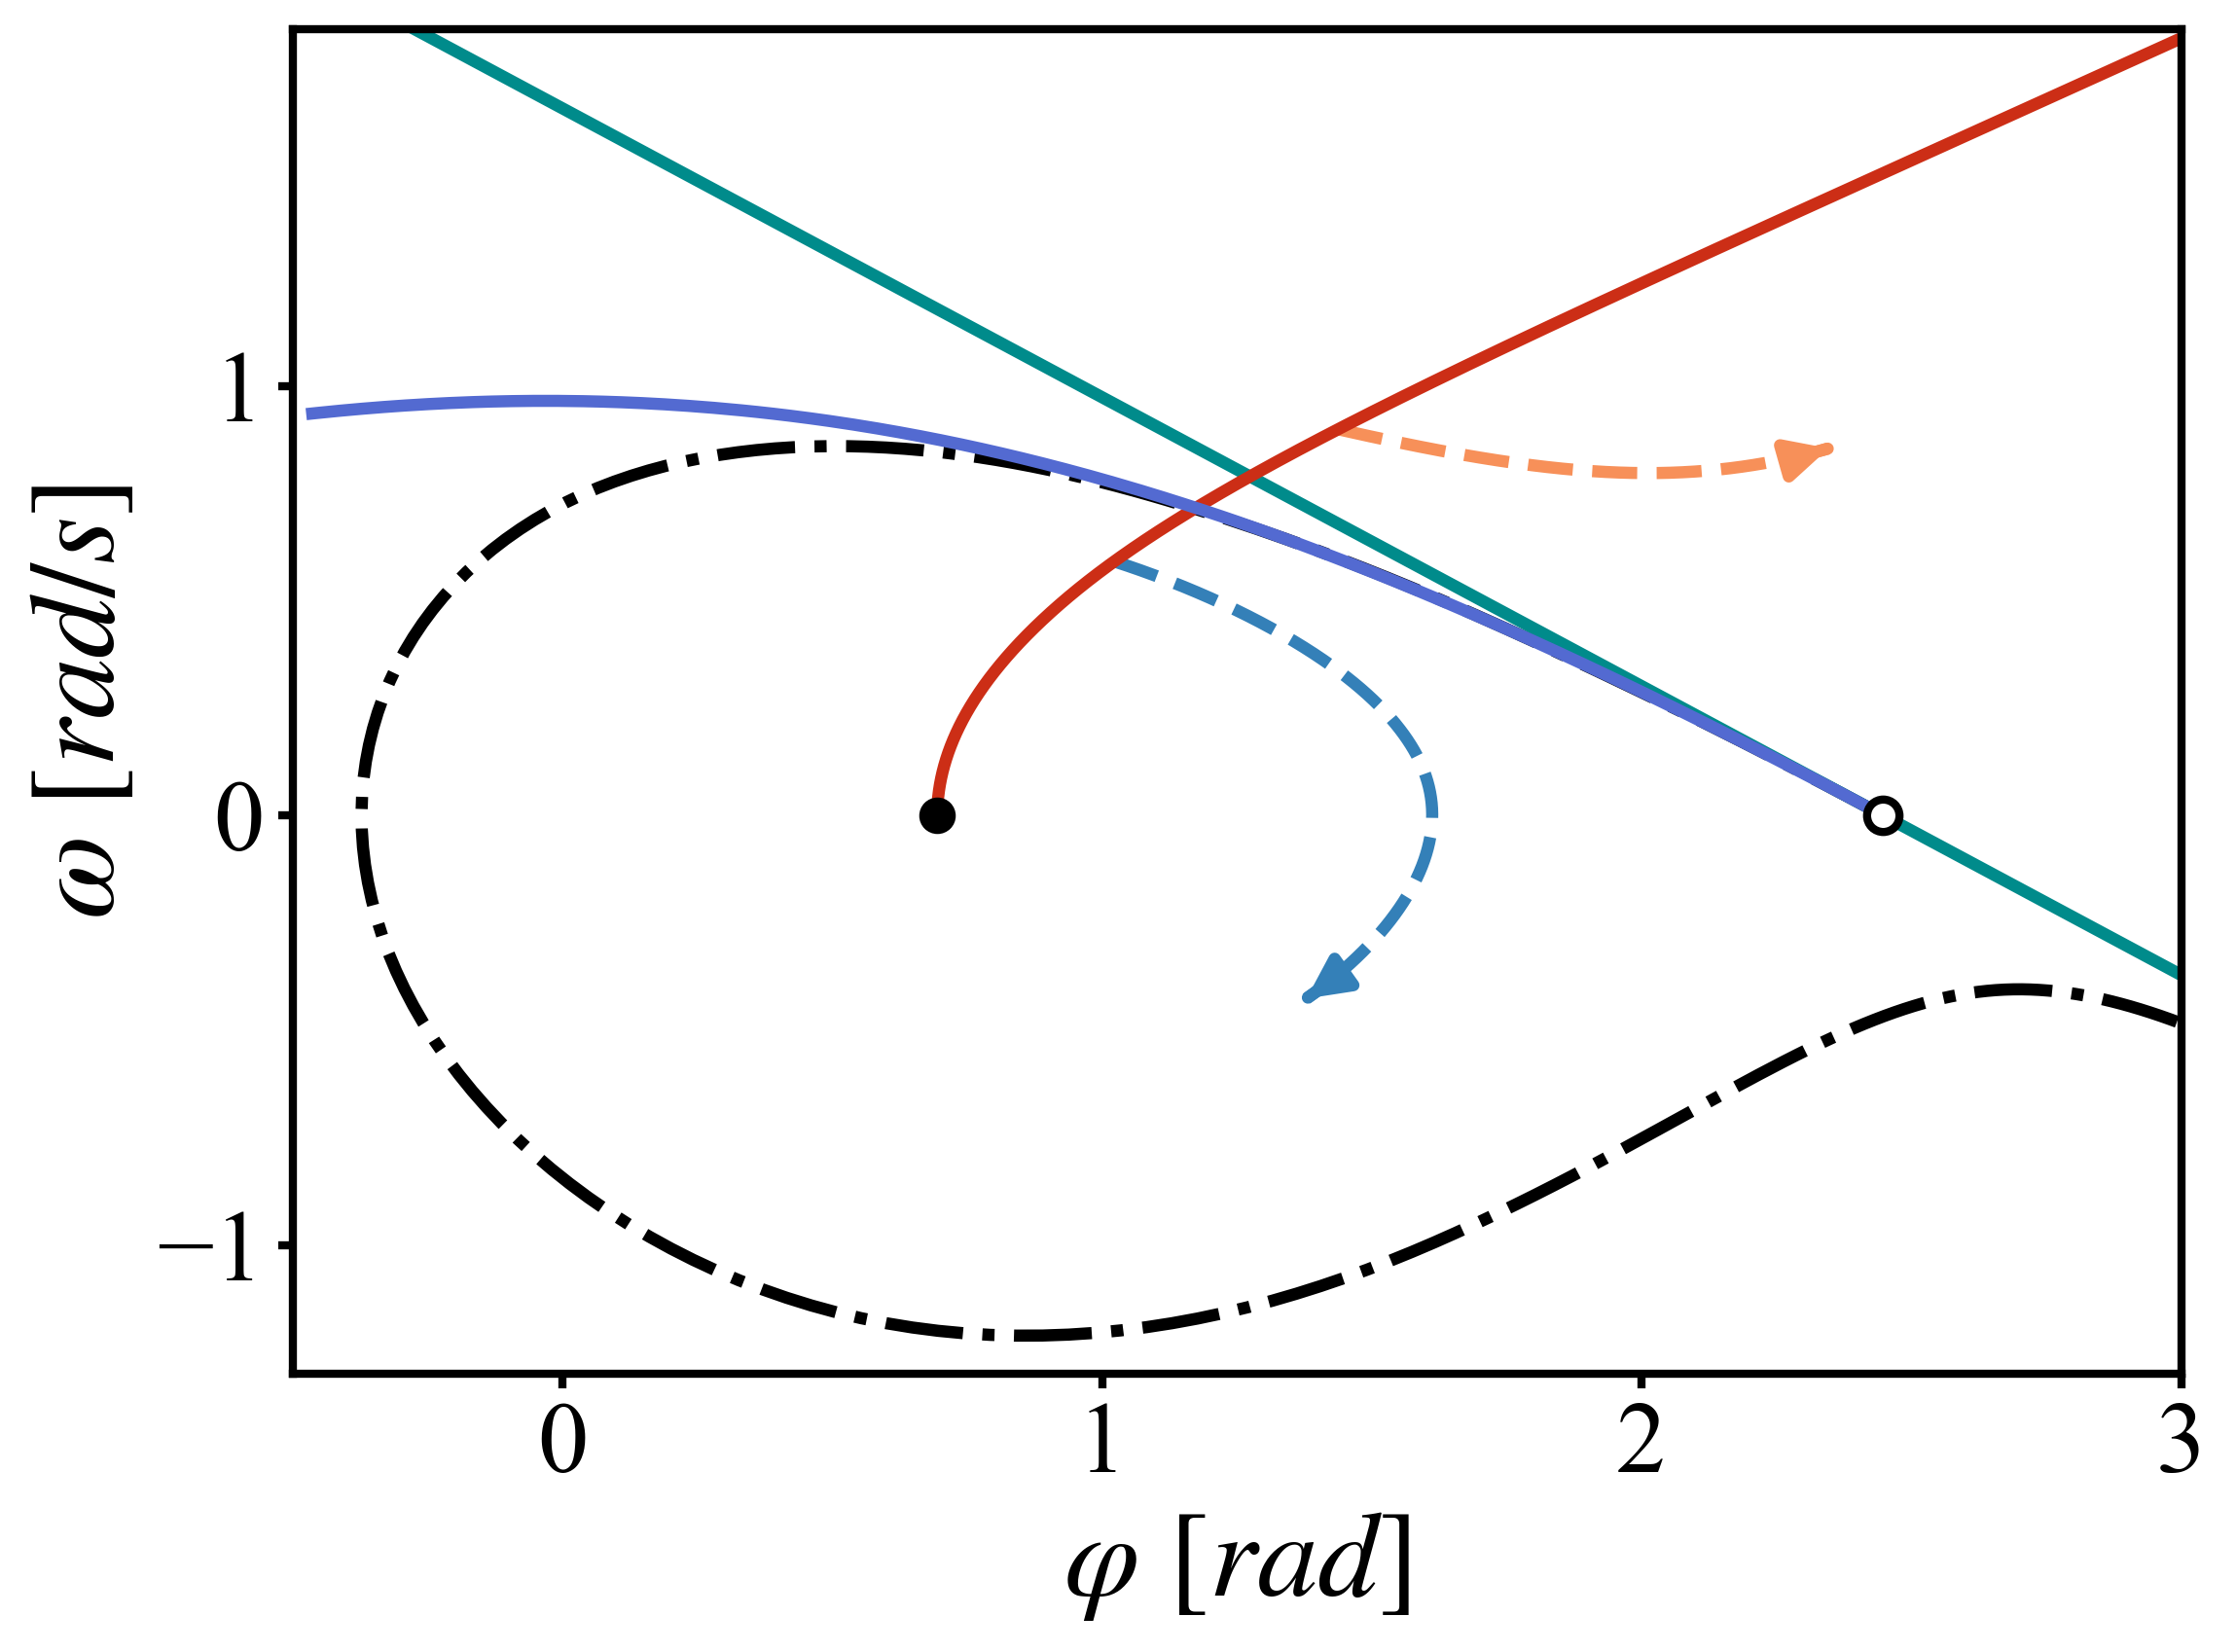

In [20]:
plt.figure(figsize=(8, 6))

# 吸引域边界
# 1. 摄动解
plt.plot(x_rg, y_rg , label=f'{rg_order}th-order RG Solution', color="#536AD1", linewidth=3, zorder=5)

# 2. 数值解
plt.plot(x_num,y_num, linestyle='-.', label='Numerical Solution', color='black', linewidth=3)

# 3. 线性近似
plt.plot(x_linear, y_linear, linestyle='-', label='Linear Approach', color='#008B8B', linewidth=3)

# 相空间流场
# plt.streamplot(x_grid, y_grid, dx_grid, dy_grid, color='#c2bdde', density=1, linewidth=1, arrowsize=1,zorder=0)

# 故障后曲线
plt.plot(x_aft_1, y_aft_1, linestyle='--', color='#3480b8', linewidth=3)
plt.plot(x_aft_2, y_aft_2, linestyle='--', color='#f79059', linewidth=3)

# 故障曲线
plt.plot(x_fault, y_fault, linestyle='-', label='During-fault', color="#CC2E16", linewidth=3)

# 在曲线1的末端加箭头
plt.annotate('', 
             xy=(x_aft_1[-1], y_aft_1[-1]),  # 曲线1的最后一个点
             xytext=(x_aft_1[-2], y_aft_1[-2]),  # 曲线1倒数第二个点
             arrowprops=dict(color='#3480b8', arrowstyle="-|>", lw=3, mutation_scale=20))  # 增加mutation_scale控制箭头大小

# 在曲线2的末端加箭
plt.annotate('', 
             xy=(x_aft_2[-1], y_aft_2[-1]),  # 曲线2的最后一个点
             xytext=(x_aft_2[-2], y_aft_2[-2]),  # 曲线2倒数第二个点
             arrowprops=dict(color='#f79059', arrowstyle="-|>", lw=3, mutation_scale=20)) 

# 在图上标记交点
# if idx_rg is not None:
#     plt.scatter(x_fault[idx_rg], y_fault[idx_rg], color="#536AD1", s=80, zorder=20, marker='x',
#                 label=f'RG Intersection (cct={idx_rg*delta_t/K2:.4f}s)')
# if idx_num is not None:
#     plt.scatter(x_fault[idx_num], y_fault[idx_num], color='black', s=80, zorder=10, marker='x',
#                 label=f'Numerical Intersection (cct={idx_num*delta_t/K2:.4f}s)')
# if idx_linear is not None:
#     plt.scatter(x_fault[idx_linear], y_fault[idx_linear], color='#008B8B', s=80, zorder=10, marker='x',
#                 label=f'Linear Intersection (cct={idx_linear*delta_t/K2:.4f}s)')

plt.xlabel(r'$\mathit{\varphi}\ [\mathit{rad}]$',  # φ斜体 + [rad]斜体
           fontsize=30,
           math_fontfamily='stix')

plt.ylabel(r'$\mathit{\omega}\ [\mathit{rad/s}]$',  # ω斜体 + [rad/s]斜体
           fontsize=30,
           math_fontfamily='stix')
# 鞍点
plt.plot(xs_val, ys_val, marker='o', color='black',zorder=20, ms=8,fillstyle='full', markerfacecolor='white',markeredgewidth=2 )
# 初始点
plt.plot(xini_val, yini_val, marker='o', color='black',zorder=20, ms=8, linestyle='None')
plt.tick_params(axis='both', which='major', labelsize=25)
# plt.legend(frameon=True,edgecolor='black',fancybox=False,shadow=True,loc='lower left', fontsize=28)
plt.ylim(-1.3, 1.83)
plt.xlim(-0.5, 3)
plt.show()

In [21]:
K2

35.7506990276033